In [1]:
import os
import asyncio
import psycopg2
from semantic_kernel.functions import kernel_function
from typing import Annotated
from dotenv import load_dotenv

load_dotenv()

class QueryPostgresPlugin:
    """
    Plugin to query a PostgreSQL database using a SQL query.
    The SQL query is provided as an input parameter.
    """

    def __init__(self, connection_string: str) -> None:
        self._connection_string = connection_string

    @staticmethod
    def __clean_sql_query__(sql_query: str) -> str:
        """Clean the SQL query to remove potentially harmful characters."""
        return sql_query.replace(";", "").replace("\n", " ")

    @kernel_function(
        name="query_postgres",
        description="Query a PostgreSQL database using a SQL query and return the results as a string.")
    async def query_postgres(
        self,
        sql_query: Annotated[str, "SQL query to be executed"]) -> Annotated[str, "The results of the SQL query as a formatted string"]:
        """
        Executes the SQL query against PostgreSQL using psycopg2 and returns the results.
        Args:
            sql_query: The SQL query to be executed.
        Returns:
            A string representation of the query results or an error message.
        """
        def run_query():
            try:
                conn = psycopg2.connect(self._connection_string)
                cur = conn.cursor()
                # Clean the SQL query.
                query = self.__clean_sql_query__(sql_query)
                cur.execute(query)
                # Retrieve column names before fetching rows.
                col_names = [desc[0] for desc in cur.description] if cur.description else []
                rows = cur.fetchall()
                cur.close()
                conn.close()
                if not rows:
                    return "No results found."
                # Convert rows to a list of dictionaries if column names are available.
                results = [dict(zip(col_names, row)) for row in rows] if col_names else rows
                return str(results)
            except Exception as e:
                return f"Error executing query: {e}"
        
        # Run the synchronous query code in a thread.
        result = await asyncio.to_thread(run_query)
        return result

# Define an asynchronous function to run the query plugin.
async def query_plugin():
    conn_str = os.getenv("POSTGRES_CONNECTION_STRING")
    if not conn_str:
        print("Please set POSTGRES_CONNECTION_STRING in your environment.")
        return

    plugin_instance = QueryPostgresPlugin(conn_str)
    
    sql_query = 'SELECT * FROM public."actor" LIMIT 5'
    
    result = await plugin_instance.query_postgres(sql_query)
    print("Query Plugin Result:")
    print(result)

await query_plugin()



Query Plugin Result:
[{'actor_id': 1, 'first_name': 'Penelope', 'last_name': 'Guiness', 'last_update': datetime.datetime(2013, 5, 26, 14, 47, 57, 620000)}, {'actor_id': 2, 'first_name': 'Nick', 'last_name': 'Wahlberg', 'last_update': datetime.datetime(2013, 5, 26, 14, 47, 57, 620000)}, {'actor_id': 3, 'first_name': 'Ed', 'last_name': 'Chase', 'last_update': datetime.datetime(2013, 5, 26, 14, 47, 57, 620000)}, {'actor_id': 4, 'first_name': 'Jennifer', 'last_name': 'Davis', 'last_update': datetime.datetime(2013, 5, 26, 14, 47, 57, 620000)}, {'actor_id': 5, 'first_name': 'Johnny', 'last_name': 'Lollobrigida', 'last_update': datetime.datetime(2013, 5, 26, 14, 47, 57, 620000)}]


In [2]:
class GetSchemaPlugin:
    """
    Plugin to retrieve the schema of tables from a PostgreSQL database.
    It returns table schema, table name, column name, and data type for each column.
    """

    def __init__(self, connection_string: str) -> None:
        self._connection_string = connection_string

    @kernel_function(
        name="get_schema",
        description="Retrieves the schema of tables from the PostgreSQL database. "
                    "Returns table names, column names, and data types as a formatted string.")
    async def get_schema(
        self,
        _: Annotated[str, "Unused parameter for compatibility"]
    ) -> Annotated[str, "The schema details as a formatted string"]:
        """
        Connects to PostgreSQL using psycopg2, retrieves schema details from the information_schema.columns view,
        and returns the results as a formatted string.
        """
        def run_schema_query():
            try:
                # Connect to the PostgreSQL database.
                conn = psycopg2.connect(self._connection_string)
                cur = conn.cursor()

                # Query to retrieve schema details excluding internal schemas.
                query = """
                    SELECT table_schema, table_name, column_name, data_type
                    FROM information_schema.columns
                    WHERE table_schema NOT IN ('information_schema', 'pg_catalog')
                    ORDER BY table_schema, table_name, ordinal_position;
                """
                cur.execute(query)
                rows = cur.fetchall()
                cur.close()
                conn.close()

                if not rows:
                    return "No schema information found."

                # Format the output.
                schema_details = []
                for table_schema, table_name, column_name, data_type in rows:
                    schema_details.append(f"{table_schema}.{table_name} - {column_name} ({data_type})")
                return "\n".join(schema_details)
            except Exception as e:
                return f"Error retrieving schema: {e}"

        # Run the synchronous schema query in a thread.
        result = await asyncio.to_thread(run_schema_query)
        return result

# Define an asynchronous function to run the schema plugin.
async def schema_plugin():
    conn_str = os.getenv("POSTGRES_CONNECTION_STRING")
    if not conn_str:
        print("Please set POSTGRES_CONNECTION_STRING in your environment.")
        return

    plugin_instance = GetSchemaPlugin(conn_str)
    
    result = await plugin_instance.get_schema("")
    print("Schema Plugin Result:")
    print(result)

await schema_plugin()

Schema Plugin Result:
public.actor - actor_id (integer)
public.actor - first_name (character varying)
public.actor - last_name (character varying)
public.actor - last_update (timestamp without time zone)
public.actor_info - actor_id (integer)
public.actor_info - first_name (character varying)
public.actor_info - last_name (character varying)
public.actor_info - film_info (text)
public.address - address_id (integer)
public.address - address (character varying)
public.address - address2 (character varying)
public.address - district (character varying)
public.address - city_id (smallint)
public.address - postal_code (character varying)
public.address - phone (character varying)
public.address - last_update (timestamp without time zone)
public.category - category_id (integer)
public.category - name (character varying)
public.category - last_update (timestamp without time zone)
public.city - city_id (integer)
public.city - city (character varying)
public.city - country_id (smallint)
public.

In [3]:
import os
import sys
from dotenv import load_dotenv
import asyncio
import logging
import requests
import uuid
import json
from datetime import datetime
from typing import List, Dict, Any, Optional
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AccessToken
from semantic_kernel import Kernel
from semantic_kernel.utils.logging import setup_logging
from semantic_kernel.functions import kernel_function
from semantic_kernel.connectors.ai.function_choice_behavior import FunctionChoiceBehavior
from semantic_kernel.connectors.ai.chat_completion_client_base import ChatCompletionClientBase
from semantic_kernel.agents import ChatCompletionAgent, ChatHistoryAgentThread
from semantic_kernel.functions.kernel_arguments import KernelArguments
from semantic_kernel.contents.chat_history import ChatHistory
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions.kernel_function_from_prompt import KernelFunctionFromPrompt
from semantic_kernel.connectors.ai.open_ai.prompt_execution_settings.azure_chat_prompt_execution_settings import (
    AzureChatPromptExecutionSettings,
)
from semantic_kernel.connectors.ai.open_ai import (
    AzureChatCompletion,
    AzureChatPromptExecutionSettings,
)
# def setup_logging():
#     logging.basicConfig(level=logging.DEBUG)

load_dotenv()

print(os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"))
kernel = Kernel()
kernel.add_service(AzureChatCompletion(service_id=os.getenv('GLOBAL_LLM_SERVICE')))

settings = kernel.get_prompt_execution_settings_from_service_id(os.getenv("GLOBAL_LLM_SERVICE"))
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

conn_str = os.getenv("POSTGRES_CONNECTION_STRING")
if not conn_str:
    raise ValueError("POSTGRES_CONNECTION_STRING environment variable not set.")

query_plugin = QueryPostgresPlugin(conn_str)
schema_plugin = GetSchemaPlugin(conn_str)

agent = ChatCompletionAgent(
    kernel=kernel,
    name="SQLAssistantAgent",
    instructions="""
You are a helpful assistant that retrieves data from a PostgreSQL database.
When a user asks for information, get schema using GetSchemaPlugin. Look for relevant tables and columns that will answer user question and generate a SQL query.
Generate SQL query you are going to execute and then use the QueryPostgresPlugin's query_postgres function.
The tables reside in the public schema of the database so use following format: public."table_name",  for example: 'SELECT * FROM public."actor" LIMIT 5'.
Always return the result of the SQL query as a json.
""",
    plugins=[schema_plugin, query_plugin],
)

user_input = "Show me top 5 rows from the actor table."
thread: ChatHistoryAgentThread = None
print(f"# User: {user_input}")
response = await agent.get_response(messages=user_input, thread=thread)
print(f"# {response.name}: {response}")
thread = response.thread
await thread.delete() if thread else None

gpt-4o
# User: Show me top 5 rows from the actor table.
# SQLAssistantAgent: Here are the top 5 rows from the "actor" table:

```json
[
  {
    "actor_id": 1,
    "first_name": "Penelope",
    "last_name": "Guiness",
    "last_update": "2013-05-26T14:47:57.620000"
  },
  {
    "actor_id": 2,
    "first_name": "Nick",
    "last_name": "Wahlberg",
    "last_update": "2013-05-26T14:47:57.620000"
  },
  {
    "actor_id": 3,
    "first_name": "Ed",
    "last_name": "Chase",
    "last_update": "2013-05-26T14:47:57.620000"
  },
  {
    "actor_id": 4,
    "first_name": "Jennifer",
    "last_name": "Davis",
    "last_update": "2013-05-26T14:47:57.620000"
  },
  {
    "actor_id": 5,
    "first_name": "Johnny",
    "last_name": "Lollobrigida",
    "last_update": "2013-05-26T14:47:57.620000"
  }
]
```


In [4]:
from semantic_kernel.agents import AssistantAgentThread, AzureAssistantAgent
from semantic_kernel.contents import StreamingFileReferenceContent

logging.basicConfig(level=logging.ERROR)

In [20]:
client, model = AzureAssistantAgent.setup_resources()
code_interpreter_tool, code_interpreter_tool_resources = AzureAssistantAgent.configure_code_interpreter_tool()


async def download_file_content(agent: AzureAssistantAgent, file_id: str):
    try:
        # Fetch the content of the file using the provided method
        response_content = await agent.client.files.content(file_id)

        # Use the current working directory for file saving
        file_path = os.path.join(
            os.getcwd(),  # current working directory
            f"{file_id}.png",  # modify as needed for file extension or naming
        )

        # Save content to a file
        with open(file_path, "wb") as file:
            file.write(response_content.content)

        print(f"File saved to: {file_path}")
    except Exception as e:
        print(f"An error occurred while downloading file {file_id}: {str(e)}")


async def download_response_image(agent: AzureAssistantAgent, file_ids: list[str]):
    if file_ids:
        for file_id in file_ids:
            await download_file_content(agent, file_id)

definition = await client.beta.assistants.create(
    model=model,
    name="CodeRunner",
    instructions="""
    SQL Assistant Agent will provide you the data in JSON format. Never ask if the user wants a chart or graph, start analyzing the data and generating them automatically.
    1. Parse the JSON into Python data structures.
    2. Execute the Python code needed to generate a chart or graph.
    3. Save the chart as a PNG file.
    4. Upload PNG via the code‐interpreter tool and return its file reference (FileReferenceContent).
    Always format your **final answer** in markdown—do not simply return code blocks.  
    Include the actual image reference alongside any analysis.  
    Return file path for that the chart was saved to.
    """,
    tools=code_interpreter_tool,
    tool_resources=code_interpreter_tool_resources,
)
code_agent = AzureAssistantAgent(
    client=client,
    definition=definition,
)

In [21]:
from semantic_kernel.contents import ChatHistoryTruncationReducer
from semantic_kernel.agents import AgentGroupChat
from semantic_kernel.agents.strategies import (
    KernelFunctionSelectionStrategy,
    KernelFunctionTerminationStrategy,
)
# # Define a selection function to determine which agent should take the next turn.
# selection_function = KernelFunctionFromPrompt(
#     function_name="selection",
#     prompt=f"""
#         When the last message was from the USER, the next turn must be by SQLAssistantAgent.
#         When the last message was from SQLAssistantAgent, the next turn must be by CodeRunner.
#         Never choose SQLAssistantAgent immediately after CodeRunner, and never choose the same agent twice in a row.
#         Ensure that the agents do not generate the same type of content in consecutive turns.

#         Choose exactly one of:
#         - SQLAssistantAgent
#         - CodeRunner

#         RESPONSE:
#         {{$lastmessage}}
# """,
# )

# Define a termination function where the reviewer signals completion with "yes".
termination_keyword = "YES"

termination_function = KernelFunctionFromPrompt(
    function_name="termination",
    prompt=f"""
        Determine whether the conversation is complete.  
        The conversation is considered complete the moment CodeRunner uploads a chart image file.  Or when the CodeRunner agent provided final answer in markdown format.
        If the last message ({{$lastmessage}}) contains any file reference (e.g. a FileReferenceContent item), for example like this:
        1. I have created a bar chart representing the top 5 most rented movies. You can download the chart using the link below.
        2. Below is a bar chart visualizing the top 5 most rented out movies. Please find the file of the chart attached
        3. "Here is the chart you requested: ![Chart](file://path/to/chart.png)"
        respond with exactly '{termination_keyword}' and nothing else.  
        """,
        )

history_reducer = ChatHistoryTruncationReducer(target_count=5)

# Create the AgentGroupChat with selection and termination strategies.
chat = AgentGroupChat(
    agents=[agent, code_agent],
    # selection_strategy=KernelFunctionSelectionStrategy(
    #     initial_agent=agent,
    #     function=selection_function,
    #     kernel=kernel,
    #     result_parser=lambda result: str(result.value[0]).strip() if result.value[0] is not None else code_agent.name,
    #     history_variable_name="lastmessage",
    #     history_reducer=history_reducer,
    # ),
    termination_strategy=KernelFunctionTerminationStrategy(
        agents=[agent, code_agent],
        function=termination_function,
        kernel=kernel,
        result_parser=lambda result: termination_keyword in str(result.value[0]).lower(),
        history_variable_name="lastmessage",
        maximum_iterations=10,
        history_reducer=history_reducer,
    ),
)
group_chat = AgentGroupChat(
    agents=[agent, code_agent])

In [17]:
from semantic_kernel.contents import AnnotationContent, FileReferenceContent

content = "What are the top 5 most rented out movies?"
# Add the user message
await group_chat.add_chat_message(content)
print(f"# User: {content}")
file_ids = []
async for response in group_chat.invoke():
    print(f"# {response.role} - {response.name or '*'}: '{response.content}'")
    if len(response.items) > 0:
        for item in response.items:
            if (
                isinstance(agent, AzureAssistantAgent)
                or isinstance(item, (AnnotationContent, FileReferenceContent))
                and item.file_id
            ):
                print(f"\n`{item.file_id}")
                response_content = await code_agent.client.files.content(item.file_id)
                file_ids.append(item.file_id)


print("Collected file IDs:", file_ids)
await download_response_image(code_agent, file_ids)
await client.beta.assistants.delete(code_agent.id)


# User: What are the top 5 most rented out movies?
# AuthorRole.ASSISTANT - SQLAssistantAgent: 'The top 5 most rented out movies are:

1. **Bucket Brotherhood** with 34 rentals.
2. **Rocketeer Mother** with 33 rentals.
3. **Grit Clockwork** with 32 rentals.
4. **Forward Temple** with 32 rentals.
5. **Juggler Hardly** with 32 rentals.'
# AuthorRole.ASSISTANT - CodeRunner: 'import matplotlib.pyplot as plt

# Data for the chart
movies = ["Bucket Brotherhood", "Rocketeer Mother", "Grit Clockwork", "Forward Temple", "Juggler Hardly"]
rentals = [34, 33, 32, 32, 32]

# Generate the bar chart
plt.figure(figsize=(10, 6))
plt.bar(movies, rentals, color='skyblue')
plt.title('Top 5 Most Rented-Out Movies', fontsize=16)
plt.xlabel('Movies', fontsize=12)
plt.ylabel('Number of Rentals', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the chart
file_path = '/mnt/data/top_5_movies_rented.png'
plt.savefig(file_path)
plt.close()

file_path'
# AuthorRole.ASSISTANT - CodeRunner: 'To showcas

AssistantDeleted(id='asst_msRCtd0Jw7JR9jOYSaltAXKm', deleted=True, object='assistant.deleted')

Displaying 2 downloaded images:

Image: assistant-QxN147yiS2oh1GWbzh3M37.png


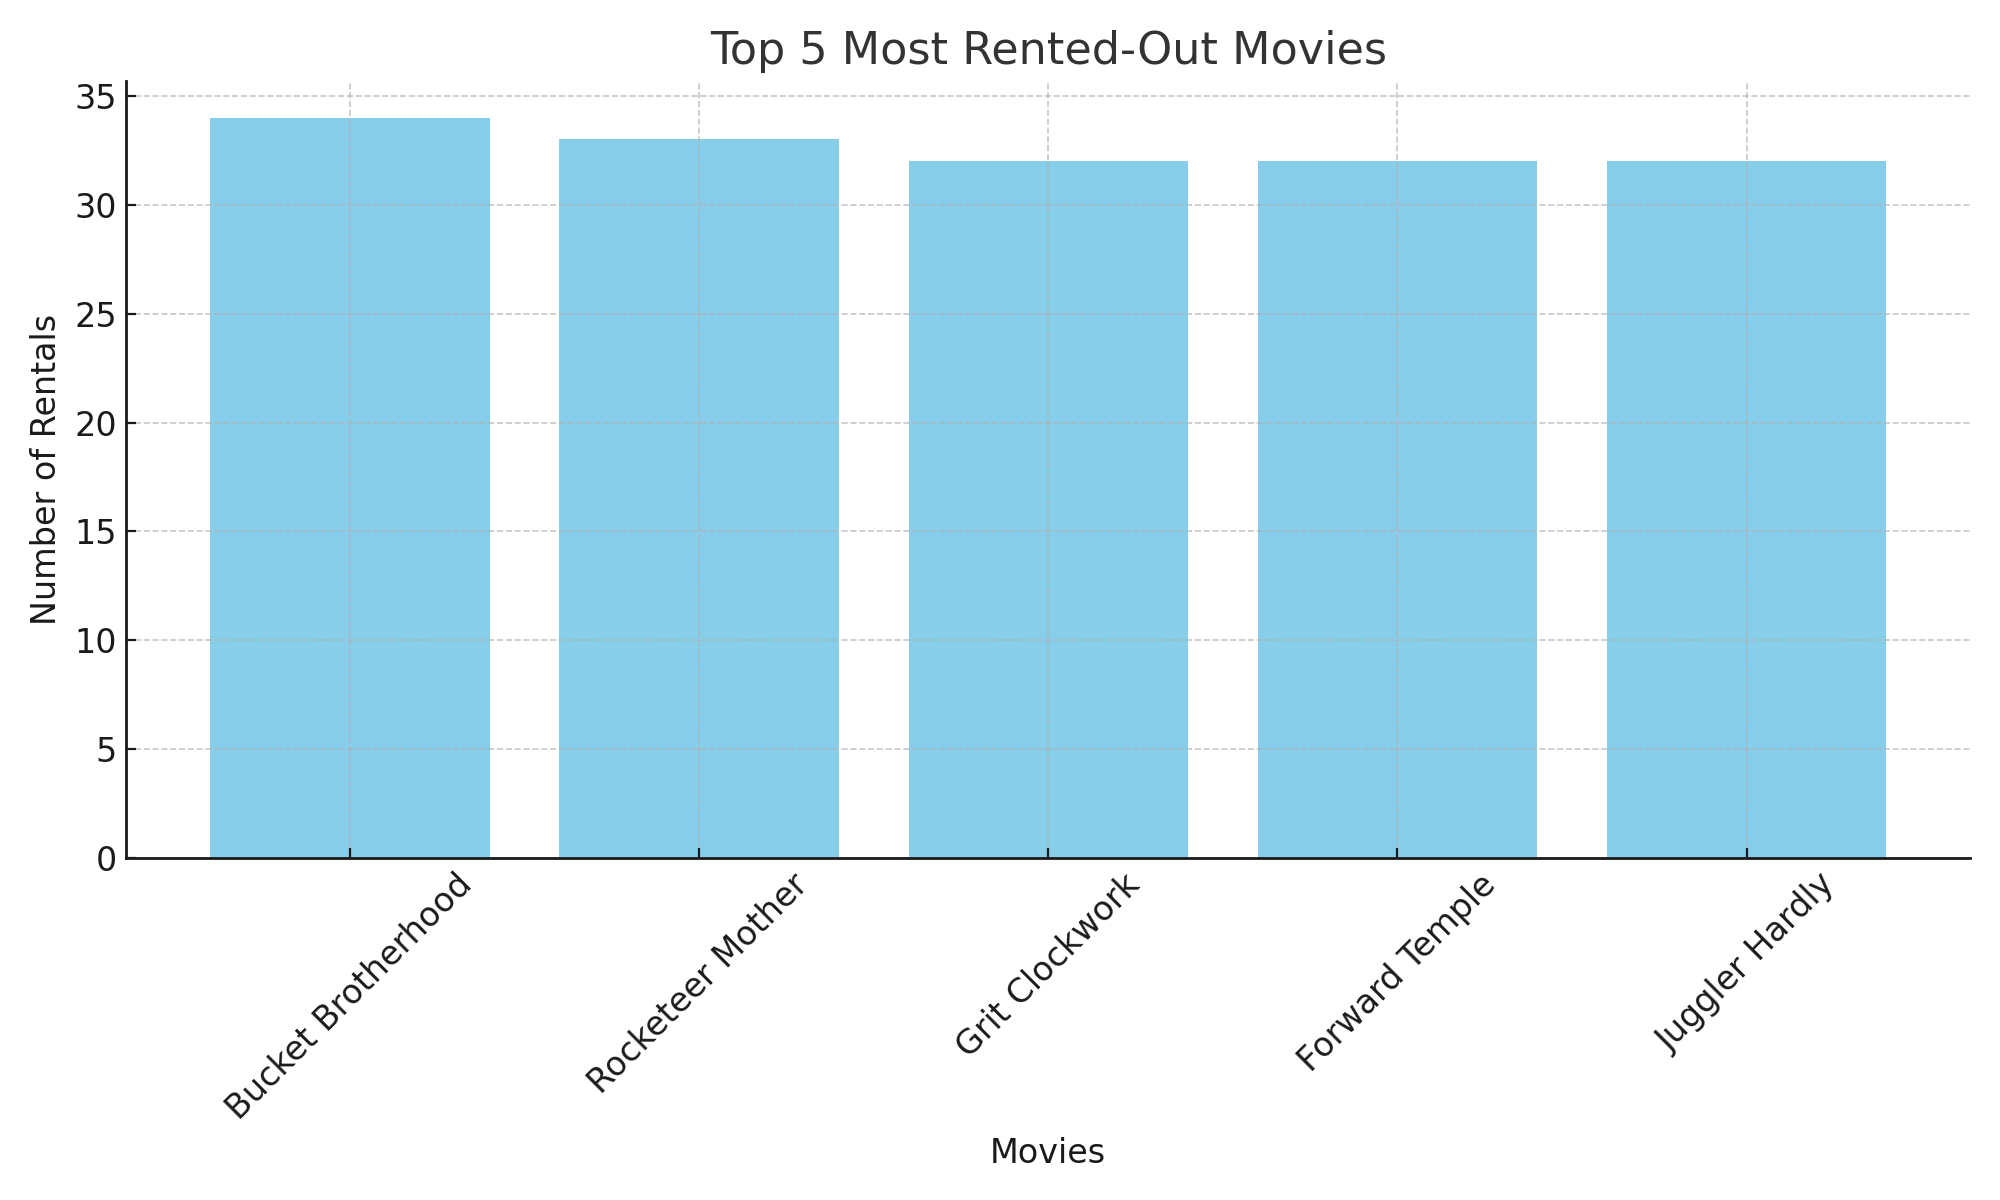


Image: assistant-TwcQ89gRaz7SCWTTgCHPwb.png


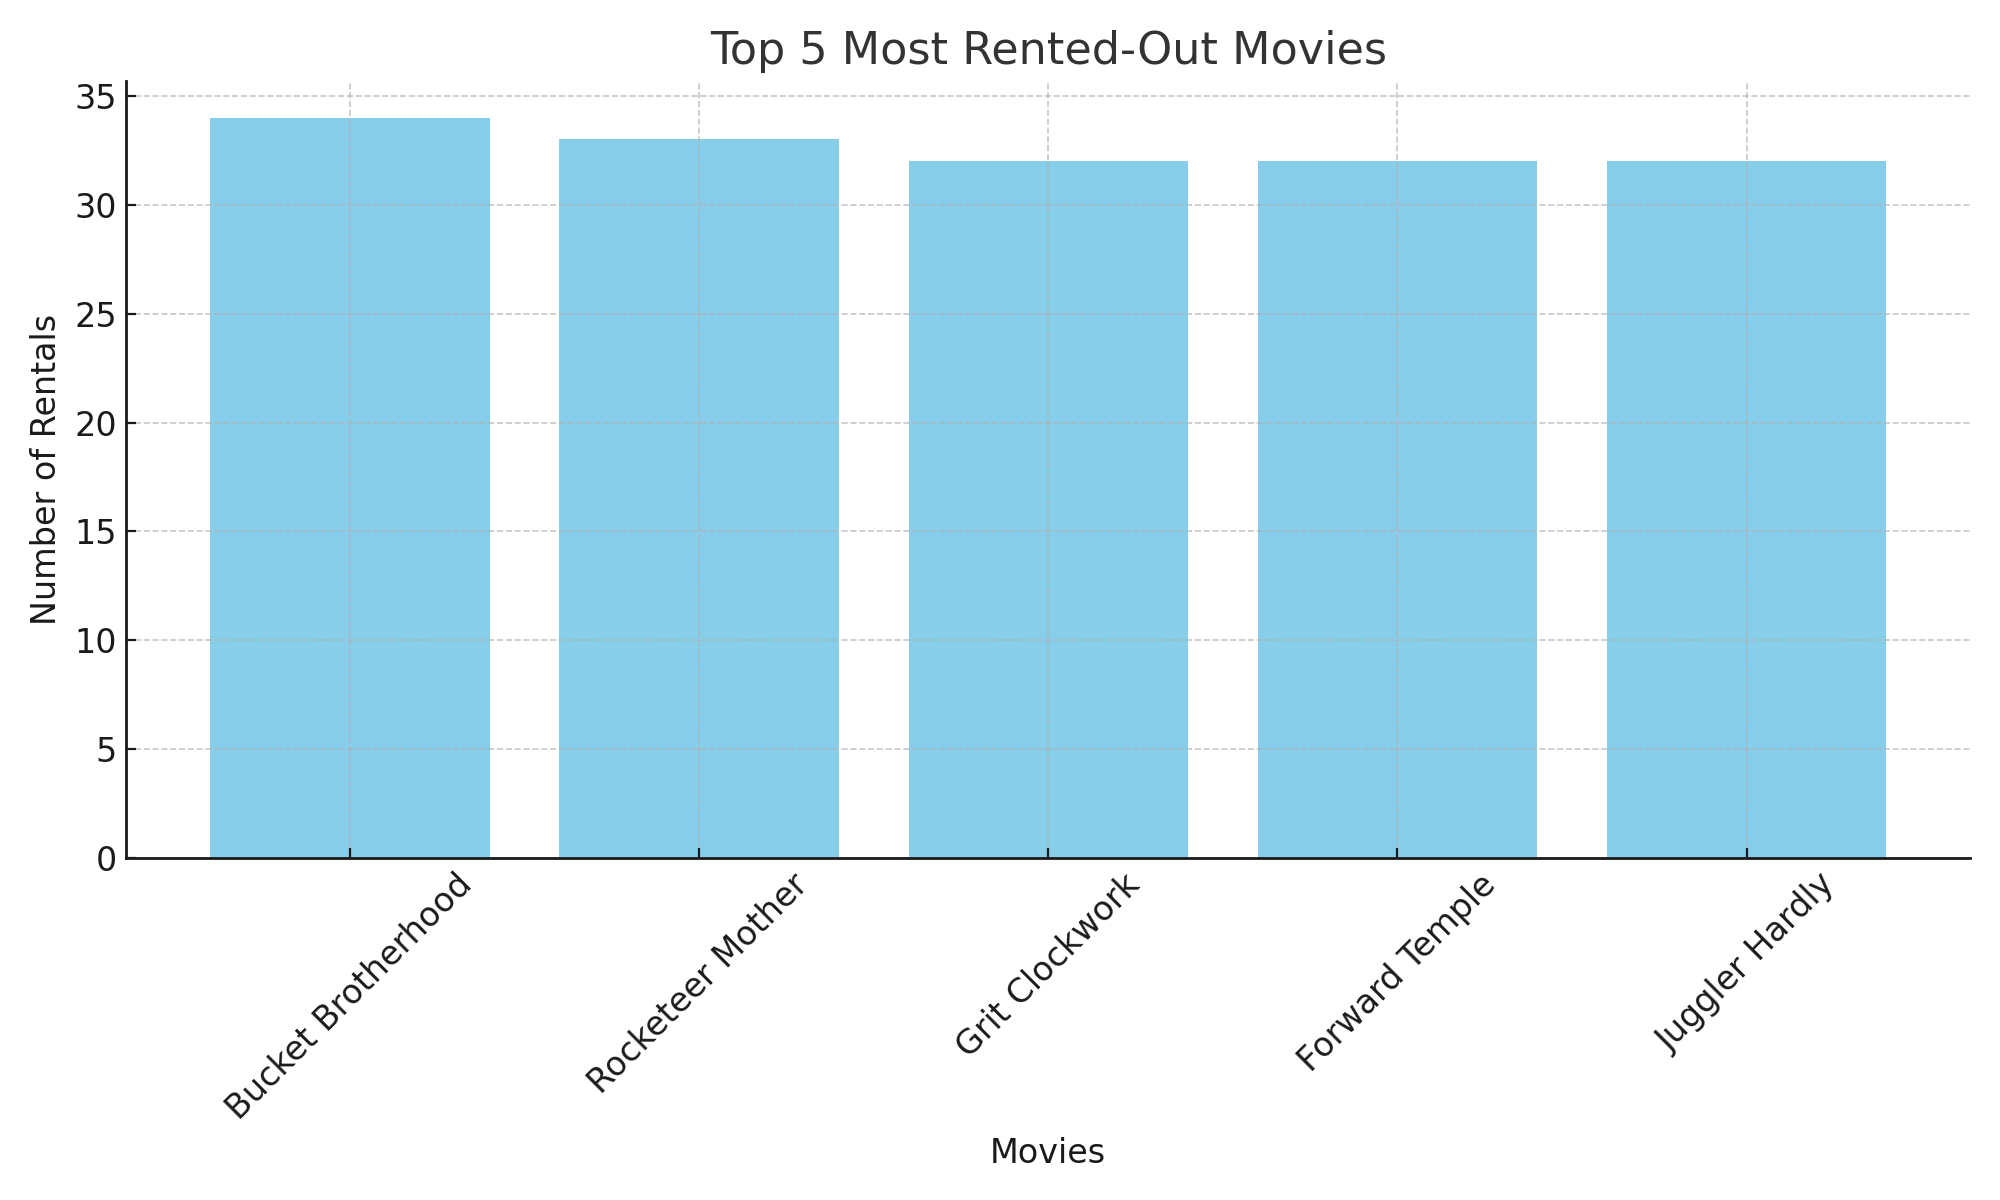

In [18]:
# New cell for displaying downloaded images
from IPython.display import Image, display
import glob

# Find all PNG files matching the pattern of downloaded files
image_files = glob.glob(f"*.png")  # Adjust pattern if needed

if image_files:
    print(f"Displaying {len(image_files)} downloaded images:")
    for img_path in image_files:
        print(f"\nImage: {img_path}")
        display(Image(img_path))
else:
    print("No downloaded images found.")

In [22]:
content = "What is the total payment revenue generated, and how does it break down by film category?"
# Add the user message
await group_chat.add_chat_message(content)
print(f"# User: {content}")
file_ids = []
async for response in group_chat.invoke():
    print(f"# {response.role} - {response.name or '*'}: '{response.content}'")
    if len(response.items) > 0:
        for item in response.items:
            if (
                isinstance(agent, AzureAssistantAgent)
                or isinstance(item, (AnnotationContent, FileReferenceContent))
                and item.file_id
            ):
                print(f"\n`{item.file_id}")
                response_content = await code_agent.client.files.content(item.file_id)
                file_ids.append(item.file_id)


print("Collected file IDs:", file_ids)
await download_response_image(code_agent, file_ids)
await client.beta.assistants.delete(code_agent.id)

# User: What is the total payment revenue generated, and how does it break down by film category?
# AuthorRole.ASSISTANT - SQLAssistantAgent: 'Here is the payment revenue breakdown by film category:

```json
[
  {"category": "Sports", "total_sales": 4892.19},
  {"category": "Sci-Fi", "total_sales": 4336.01},
  {"category": "Animation", "total_sales": 4245.31},
  {"category": "Drama", "total_sales": 4118.46},
  {"category": "Comedy", "total_sales": 4002.48},
  {"category": "New", "total_sales": 3966.38},
  {"category": "Action", "total_sales": 3951.84},
  {"category": "Foreign", "total_sales": 3934.47},
  {"category": "Games", "total_sales": 3922.18},
  {"category": "Family", "total_sales": 3830.15},
  {"category": "Documentary", "total_sales": 3749.65},
  {"category": "Horror", "total_sales": 3401.27},
  {"category": "Classics", "total_sales": 3353.38},
  {"category": "Children", "total_sales": 3309.39},
  {"category": "Travel", "total_sales": 3227.36},
  {"category": "Music", "total_s

AssistantDeleted(id='asst_oAF3iZwVauVJE1AAgSHAB9RQ', deleted=True, object='assistant.deleted')

Displaying 2 downloaded images:

Image: assistant-EjLdx6ofs8xmJKtQc5MBt1.png


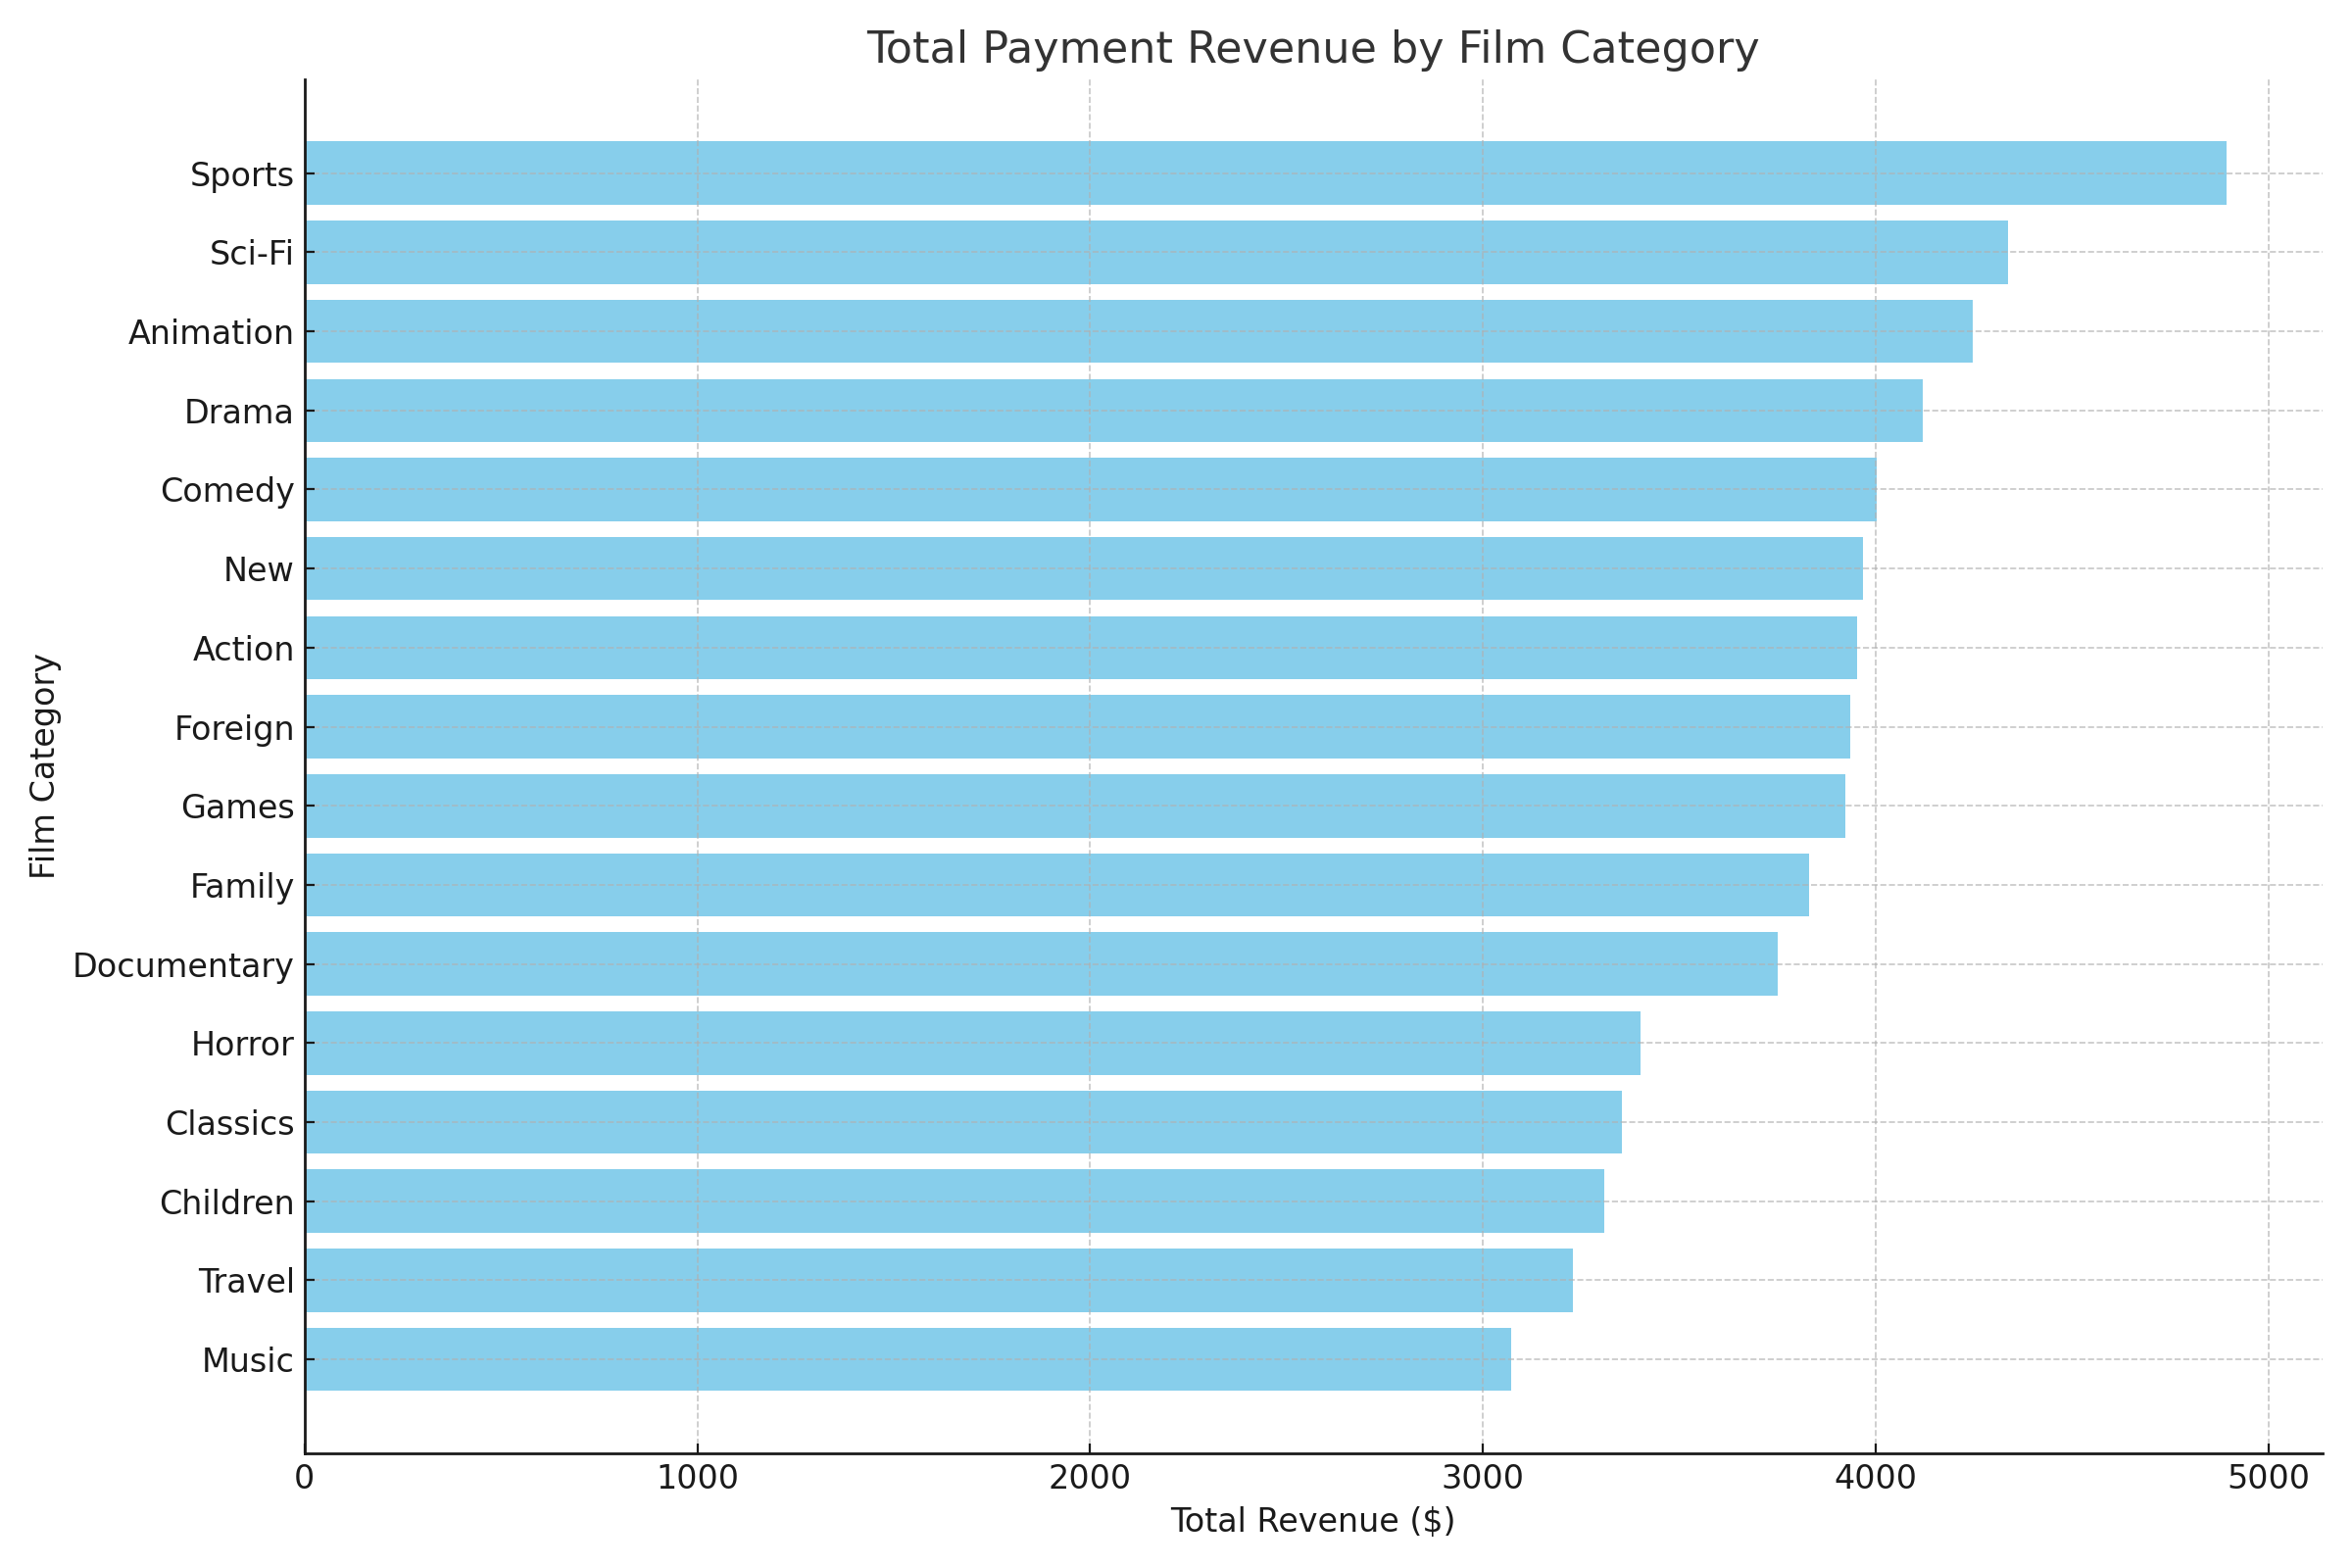


Image: assistant-TwcQ89gRaz7SCWTTgCHPwb.png


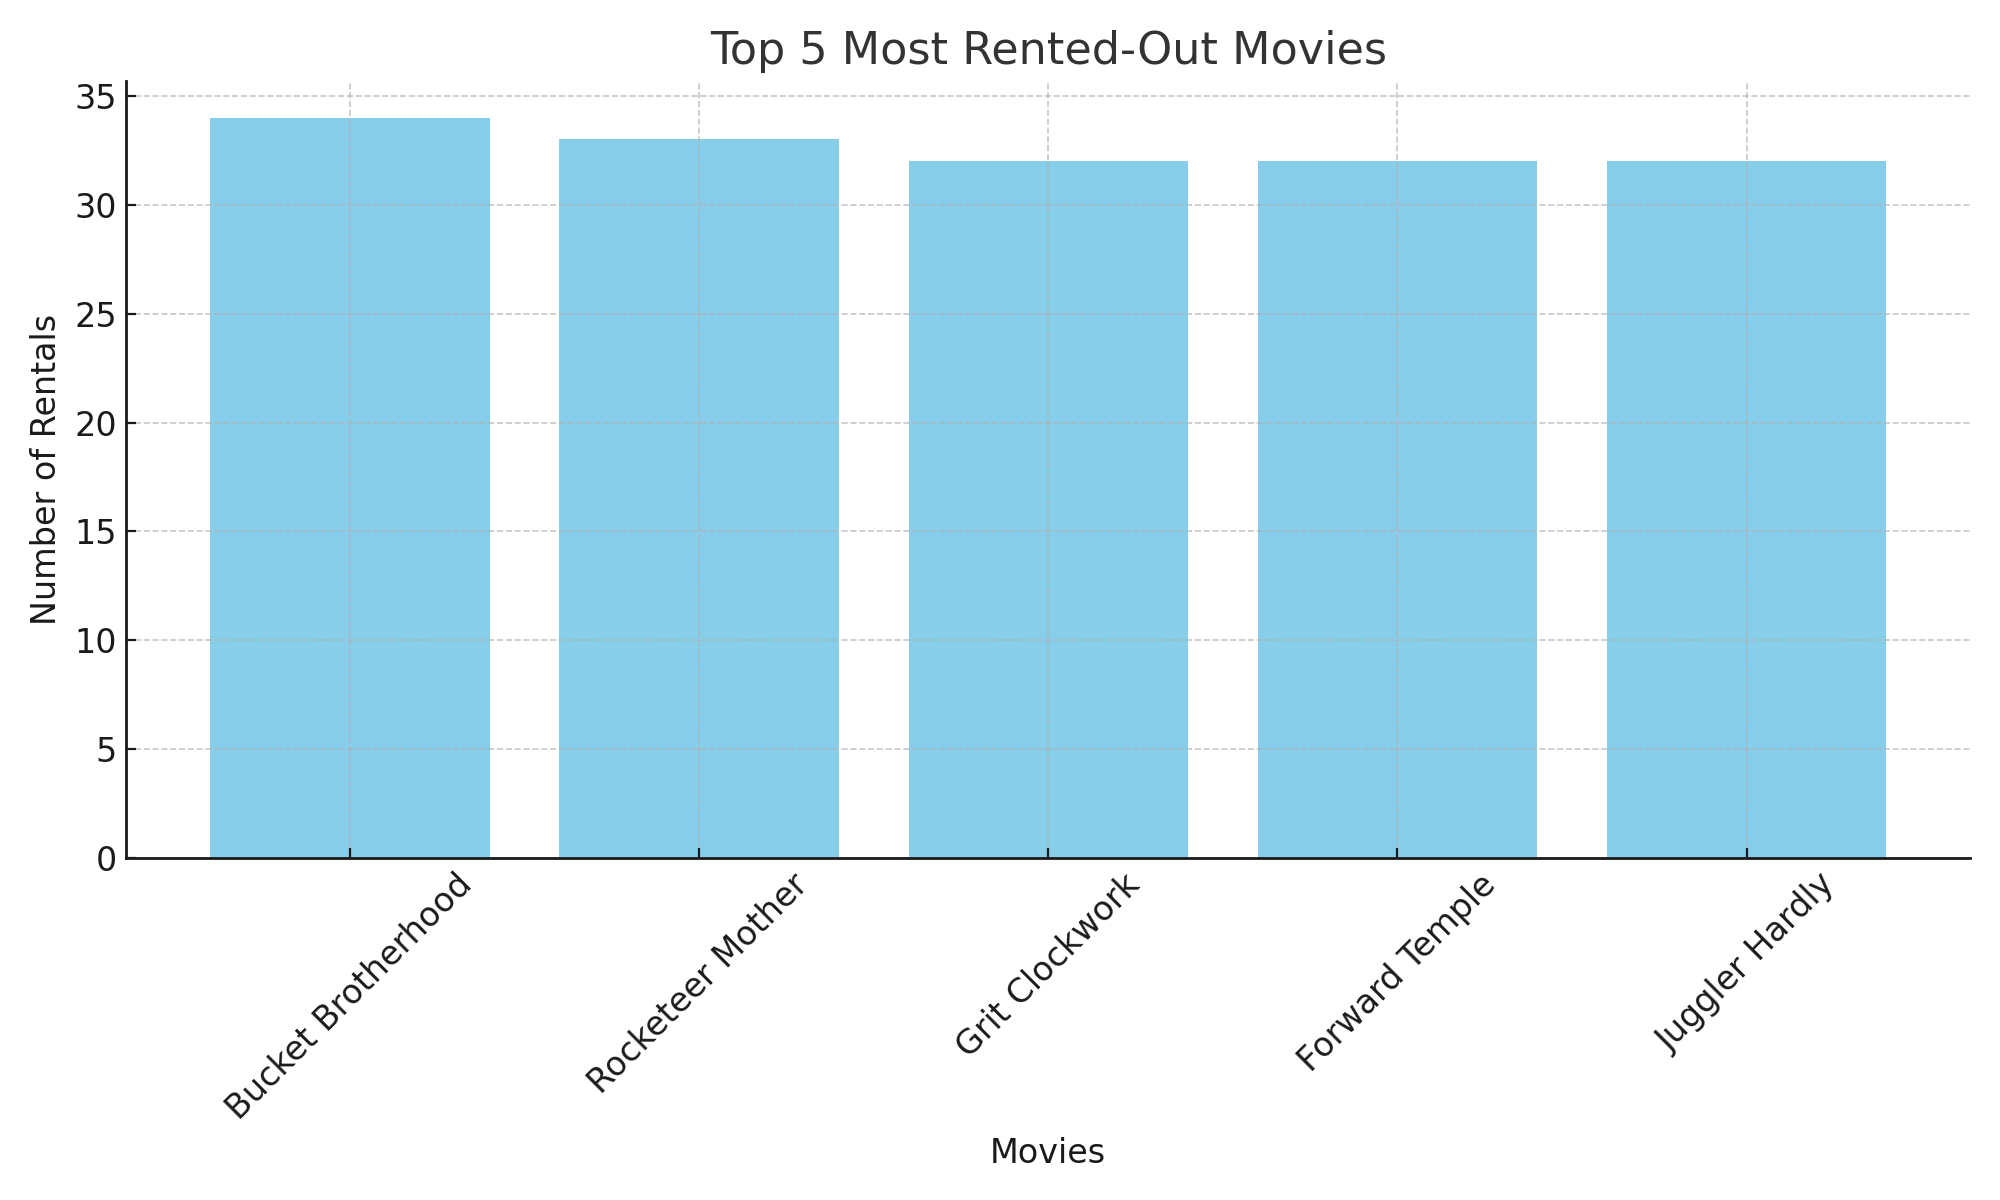

In [23]:
# New cell for displaying downloaded images
from IPython.display import Image, display
import glob

# Find all PNG files matching the pattern of downloaded files
image_files = glob.glob(f"*.png")  # Adjust pattern if needed

if image_files:
    print(f"Displaying {len(image_files)} downloaded images:")
    for img_path in image_files:
        print(f"\nImage: {img_path}")
        display(Image(img_path))
else:
    print("No downloaded images found.")